Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [4]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [5]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [6]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [7]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'originated', 'term', 'a', 'of', 'term', 'originated', 'as']


Train a skip-gram model.

In [8]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [10]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        #print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.699416
Average loss at step 2000: 4.361335
Average loss at step 4000: 3.865359
Average loss at step 6000: 3.789801
Average loss at step 8000: 3.683162
Average loss at step 10000: 3.617470
Average loss at step 12000: 3.610396
Average loss at step 14000: 3.571255
Average loss at step 16000: 3.409114
Average loss at step 18000: 3.456871
Average loss at step 20000: 3.542298
Average loss at step 22000: 3.504589
Average loss at step 24000: 3.486948
Average loss at step 26000: 3.485263
Average loss at step 28000: 3.480236
Average loss at step 30000: 3.504454
Average loss at step 32000: 3.505673
Average loss at step 34000: 3.495033
Average loss at step 36000: 3.457245
Average loss at step 38000: 3.299084
Average loss at step 40000: 3.430912
Average loss at step 42000: 3.434810
Average loss at step 44000: 3.458657
Average loss at step 46000: 3.449887
Average loss at step 48000: 3.351938
Average loss at step 50000: 3.389291
Average loss at step 52000: 3.4335

In [11]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

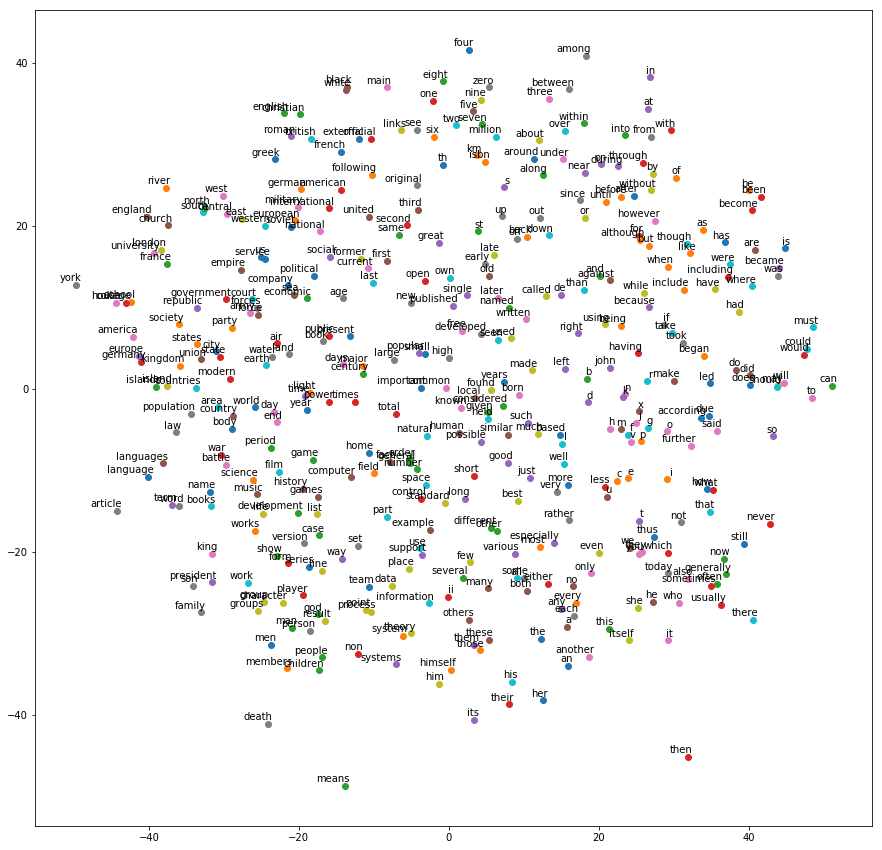

In [12]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [13]:
#https://github.com/ponderousmad/ud730/blob/master/5_word2vec.ipynb

def generate_cbow_batch(batch_size, num_skips, skip_window, sequence, index):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size, num_skips), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(sequence[index])
        index = (index + 1) % len(data)
    for i in range(batch_size):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        labels[i] = buffer[skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i][j] = buffer[target]
        buffer.append(sequence[index])
        index = (index + 1) % len(data)
    return batch, labels, index

print('data:', [reverse_dictionary[di] for di in data[:12]])

for skip_window in [1, 2]:
    cbow_index = 0
    cbow_batch, cbow_labels, cbow_index = generate_cbow_batch(8, 2 * skip_window, skip_window, data, cbow_index)
    print('\nwith skip_window = %d:' % (skip_window))
    print('    batch:', [[reverse_dictionary[bi] for bi in skips] for skips in cbow_batch])
    print('    labels:', [reverse_dictionary[li] for li in cbow_labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working']

with skip_window = 1:
    batch: [['anarchism', 'as'], ['a', 'originated'], ['as', 'term'], ['a', 'of'], ['abuse', 'term'], ['of', 'first'], ['used', 'abuse'], ['first', 'against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with skip_window = 2:
    batch: [['a', 'anarchism', 'originated', 'term'], ['originated', 'term', 'as', 'of'], ['as', 'of', 'abuse', 'a'], ['a', 'first', 'term', 'abuse'], ['term', 'of', 'used', 'first'], ['used', 'against', 'abuse', 'of'], ['against', 'first', 'early', 'abuse'], ['used', 'working', 'first', 'early']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [15]:
cbow_batch_size = 128
cbow_num_skips = 2
cbow_embedding_size = 128 # Dimension of the embedding vector.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
cbow_valid_size = 16 # Random set of words to evaluate similarity on.
cbow_valid_window = 100 # Only pick dev samples in the head of the distribution.
cbow_valid_examples = np.array(random.sample(range(cbow_valid_window), cbow_valid_size))
cbow_num_sampled = 64 # Number of negative examples to sample.

cbow_graph = tf.Graph()

with cbow_graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    cbow_train = tf.placeholder(tf.int32, shape=[cbow_batch_size, cbow_num_skips])
    cbow_labels = tf.placeholder(tf.int32, shape=[cbow_batch_size, 1])
    cbow_valid = tf.constant(cbow_valid_examples, dtype=tf.int32)

    # Variables.
    cbow_embeddings = tf.Variable(tf.random_uniform([vocabulary_size, cbow_embedding_size], -1.0, 1.0))
    print("Embeddings shape: ", cbow_embeddings.get_shape())
    
    cbow_weights = tf.Variable(tf.truncated_normal(
            [vocabulary_size, cbow_embedding_size], stddev=1.0 / math.sqrt(cbow_embedding_size)))
    print("Weights shape: ", cbow_weights.get_shape())
    
    cbow_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    cbow_embed = tf.nn.embedding_lookup(cbow_embeddings, cbow_train)
    print("Embed shape: ", cbow_embed.get_shape())
    cbow_embed = tf.reduce_sum(cbow_embed, 1)
    print("Embed shape: ", cbow_embed.get_shape())
    # Compute the softmax loss, using a sample of the negative labels each time.
    cbow_sampled_softmax = tf.nn.sampled_softmax_loss(
        weights=cbow_weights, biases=cbow_biases, inputs=cbow_embed, labels=cbow_labels, num_sampled=cbow_num_sampled, num_classes=vocabulary_size)
    print("Softmax shape: ", cbow_sampled_softmax.get_shape())
    cbow_loss = tf.reduce_mean(cbow_sampled_softmax)
    print("Loss shape: ", cbow_loss.get_shape())

    # Optimizer.
    cbow_optimizer = tf.train.AdagradOptimizer(1.0).minimize(cbow_loss)

    # Normalize the embeddings:
    cbow_norm = tf.sqrt(tf.reduce_sum(tf.square(cbow_embeddings), 1, keep_dims=True))
    cbow_normalized = cbow_embeddings / cbow_norm
    
    # Compute the similarity between validation examples and all embeddings using cosine distance:
    cbow_valid_embeddings = tf.nn.embedding_lookup(cbow_normalized, cbow_valid)
    cbow_similarity = tf.matmul(cbow_valid_embeddings, tf.transpose(cbow_normalized))

Embeddings shape:  (50000, 128)
Weights shape:  (50000, 128)
Embed shape:  (128, 2, 128)
Embed shape:  (128, 128)
Softmax shape:  (128,)
Loss shape:  ()


In [16]:
num_steps = 100001
skip_window = 1 # How many words to consider left and right.
num_skips = 2

with tf.Session(graph=cbow_graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels, cbow_index = generate_cbow_batch(cbow_batch_size, num_skips, skip_window, data, cbow_index)
        feed_dict = {cbow_train : batch_data, cbow_labels : batch_labels}
        _, l = session.run([cbow_optimizer, cbow_loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = cbow_similarity.eval()
            for i in xrange(cbow_valid_size):
                valid_word = reverse_dictionary[cbow_valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                #print(log)

    cbow_final_embeddings = cbow_normalized.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step 0: 7.949472
Average loss at step 2000: 4.098815
Average loss at step 4000: 3.562476
Average loss at step 6000: 3.386624
Average loss at step 8000: 3.247542
Average loss at step 10000: 3.179261
Average loss at step 12000: 3.206701
Average loss at step 14000: 3.162146
Average loss at step 16000: 3.176689
Average loss at step 18000: 3.129220
Average loss at step 20000: 2.989076
Average loss at step 22000: 3.070742
Average loss at step 24000: 3.038188
Average loss at step 26000: 3.005429
Average loss at step 28000: 3.032134
Average loss at step 30000: 3.001823
Average loss at step 32000: 2.828129
Average loss at step 34000: 2.955993
Average loss at step 36000: 2.940455
Average loss at step 38000: 2.945621
Average loss at step 40000: 2.937536
Average loss at step 42000: 2.949035
Average loss at step 44000: 2.956824
Average loss at step 46000: 2.907499
Average loss at step 48000: 2.8679

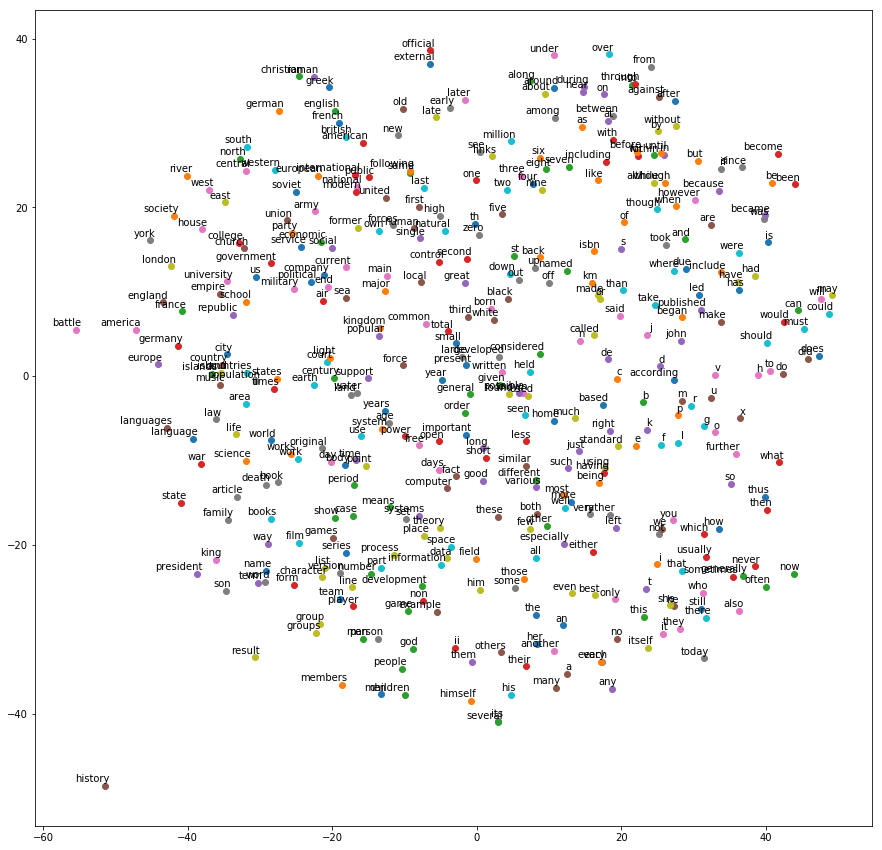

In [17]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)